In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
# conda install pandas-datareader
from pandas_datareader import data as pdr
from pandas_datareader import wb   as pwb
plt.style.use('ggplot')

# Introduction
Consider the time series data for some stock or market index price $S(t)$. What matters most is not the abolute value of the stock at any given time, but the return: the change in price after some time $\tau$. For convenience one usually considers the logarithmic change $G_{\tau}(t)$ as

$$
  G_\tau(t) \equiv \log{S(t+\tau)} - \log{S(t)}
$$

When the changes in $S$ are small, this is equivalent to the relative change in price
$$\begin{align}
    G_\tau(t) &= \ln{\left[\frac{S(t+\tau)}{S(t)}\right]} \\
    &= \ln{\left[\frac{S(t) + \Delta_\tau S(t)}{S(t)}\right]} \\
    &= \ln{\left[1 + \frac{\Delta_\tau S(t)}{S(t)}\right]} \\
    &\simeq \frac{\Delta_\tau S(t)}{S(t)} = \frac{S(t+\tau) - S(t)}{S(t)}
\end{align}
$$
where we have used the Taylor expansion of the logarithm (truncated to first order),
$$
\ln{\left( 1 + x\right)} = x - \frac{x^2}{2} + \frac{x^3}{3} + \cdots\qquad (\mathrm{for}\, \lvert x\rvert < 1)
$$

Initially, the stohastic process of price returns was modelled as Gaussian. This is a reasonable assumption if the price exhibits random and uncorrelated price bumps, similar to the random forces exerted on a colloidal particle by the surrounding water molecules. By the central limit theorem, we then know that this would give rise to a Gaussian process. Unfortunately, this is not what is observed when we analyze the price returns of real stocks

In [2]:
# Logarithmic return of price time series
def logreturn(St,tau=1):
    return np.log(St[tau:]) - np.log(St[0:-tau]) # G_tau(t) = log(S(t+tau)) - log(S(t))

# normalize data to have zero average (<x> = 0) and unit variance (<(x - <x>)^2> = 1)
def normalized(data):
    return (data - np.average(data))/np.sqrt(np.var(data))

# compute normalized probability distribution function
def pdf(data,bins=50):
    hist, edges = np.histogram(data[~np.isnan(data)], bins=bins, density=True)
    edges   = (edges[:-1] + edges[1:])/2.0
    nonzero = hist > 0.0
    return edges[nonzero], hist[nonzero]

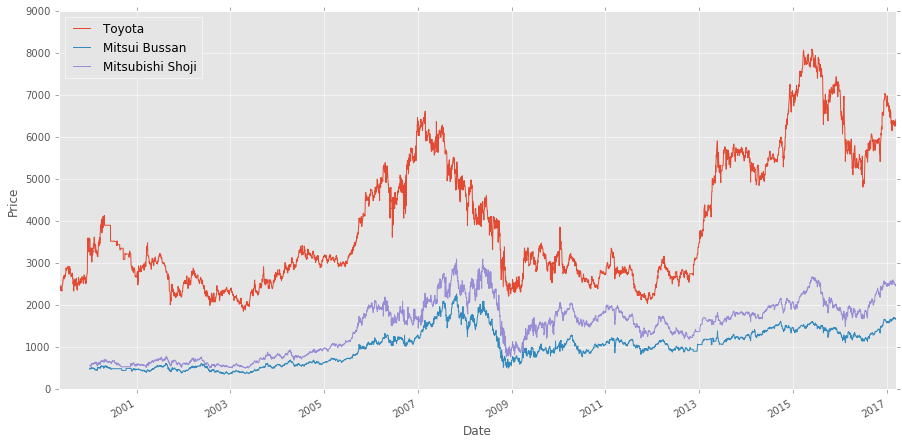

In [3]:
end_time   = datetime.now()
start_time = datetime(end_time.year - 30, 1, 1)

toyota     = pdr.DataReader('7203', 'yahoo', start_time, end_time) 
mitsui     = pdr.DataReader('8031', 'yahoo', start_time, end_time)
mitsubishi = pdr.DataReader('8058', 'yahoo', start_time, end_time)

fig,ax = plt.subplots(figsize=(15,7.5))
for stock,lbl in zip([toyota, mitsui, mitsubishi], ['Toyota', 'Mitsui Bussan', 'Mitsubishi Shoji']):
    stock['Adj Close'].plot(ax=ax, legend = True, label=lbl)
ax.set_ylabel('Price')
plt.show()

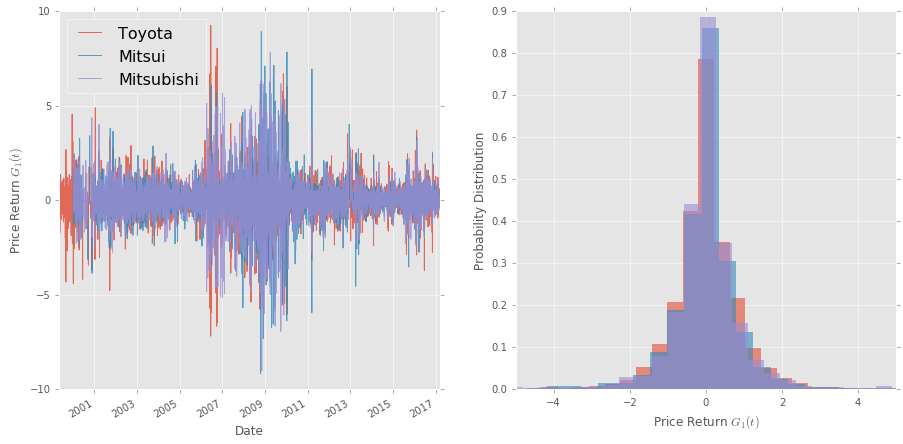

In [8]:
def computeReturn(data, name, tau):
    data[name] = pd.Series(normalized(logreturn(data['Adj Close'].values, tau)), index=data.index[:-tau])

for stock in [toyota, mitsui, mitsubishi]:
    computeReturn(stock, 'Return d1', 1)

fig, [ax,bx] = plt.subplots(figsize=(15.0, 7.5),ncols=2)
for data,lbl in zip([toyota, mitsui, mitsubishi], ['Toyota', 'Mitsui', 'Mitsubishi']):
    data['Return d1'].plot(ax=ax, alpha=0.8, legend=True, label=lbl)
    data['Return d1'].hist(ax=bx, alpha=0.6, normed=True, bins=40,lw=0)

ax.legend(loc=0, fontsize=16)
ax.set_ylabel('Price Return $G_1(t)$')
bx.set_xlabel('Price Return $G_1(t)$')
bx.set_ylabel('Probability Distribution')
bx.set_xlim([-5,5])
plt.show()

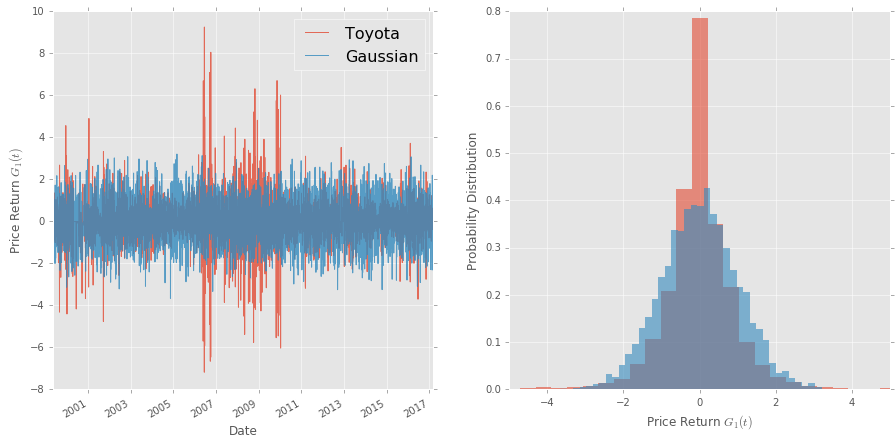

In [10]:
fig, [ax,bx] = plt.subplots(figsize=(15.0, 7.5),ncols=2)
gaussian     = pd.DataFrame(data=np.random.randn(len(toyota)), index=toyota.index, columns=['Return d1'])
for data,lbl in zip([toyota, gaussian], ['Toyota', 'Gaussian']):
    data['Return d1'].plot(ax=ax, alpha=0.8, legend=True, label=lbl)
    data['Return d1'].hist(ax=bx, alpha=0.6, normed=True, bins=40,lw=0)

ax.legend(loc=0, fontsize=16)
ax.set_ylabel('Price Return $G_1(t)$')
bx.set_xlabel('Price Return $G_1(t)$')
bx.set_ylabel('Probability Distribution')
bx.set_xlim([-5,5])
plt.show()

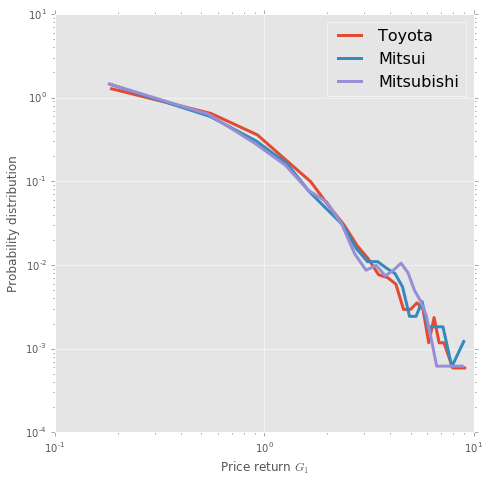

In [11]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
for data,lbl in zip([toyota, mitsui, mitsubishi], ['Toyota', 'Mitsui', 'Mitsubishi']):
    edges,hist = pdf(np.abs(data['Return d1'].values), bins=25)
    ax.plot(edges, hist, label=lbl, lw=3)
ax.set_xlabel('Price return $G_1$')
ax.set_ylabel('Probability distribution')
ax.semilogy()
ax.semilogx()
ax.legend(loc=0, fontsize=16)
plt.show()

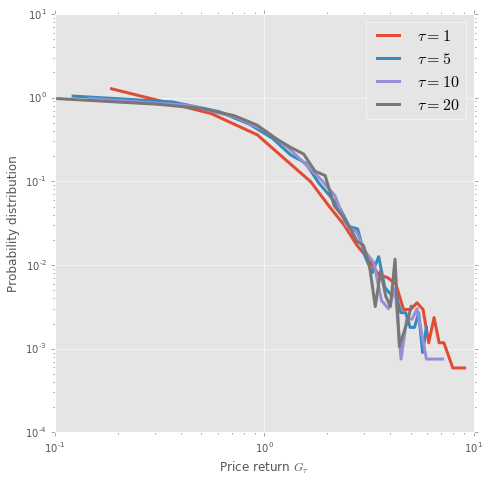

In [12]:
computeReturn(toyota, 'Return d5', 5)
computeReturn(toyota, 'Return d10', 10)
computeReturn(toyota, 'Return d20', 20)

fig, ax = plt.subplots(figsize=(7.5,7.5))
for col,lbl in zip(['Return d1', 'Return d5', 'Return d10', 'Return d20'], 
                   [r'$\tau=1$', r'$\tau=5$', r'$\tau=10$', r'$\tau=20$']):
    edges,hist = pdf(np.abs(toyota[col].values), bins=25)
    ax.plot(edges, hist, label=lbl, lw=3)
ax.set_xlabel(r'Price return $G_{\tau}$')
ax.set_ylabel(r'Probability distribution')
ax.semilogy()
ax.semilogx()
ax.legend(loc=0, fontsize=16)
plt.show()

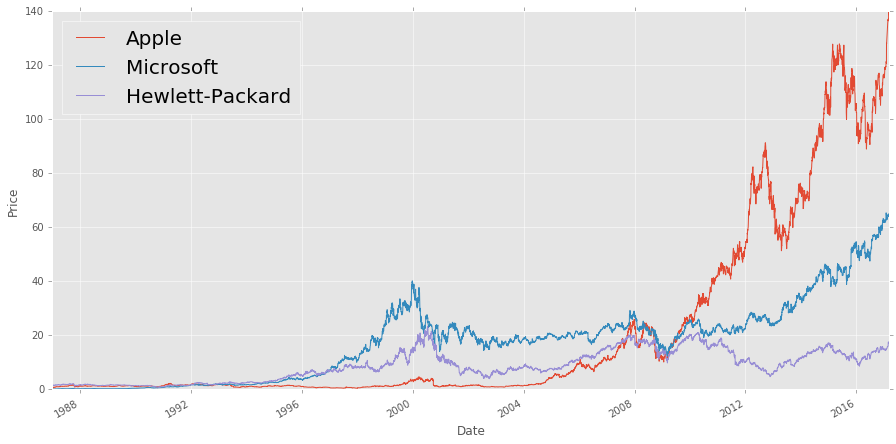

In [13]:
apple = pdr.DataReader('AAPL', 'yahoo', start_time, end_time) 
msft  = pdr.DataReader('MSFT', 'yahoo', start_time, end_time)
hpq   = pdr.DataReader('HPQ',  'yahoo', start_time, end_time)
for stock in [apple, msft, hpq]:
    computeReturn(stock, 'Return d1', 1)
    
fig,ax = plt.subplots(figsize=(15,7.5))
for stock,lbl in zip([apple, msft, hpq], ['Apple', 'Microsoft', 'Hewlett-Packard']):
    stock['Adj Close'].plot(ax=ax, legend = True, label=lbl)
ax.set_ylabel('Price')
ax.legend(loc=2, fontsize=20)
plt.show()

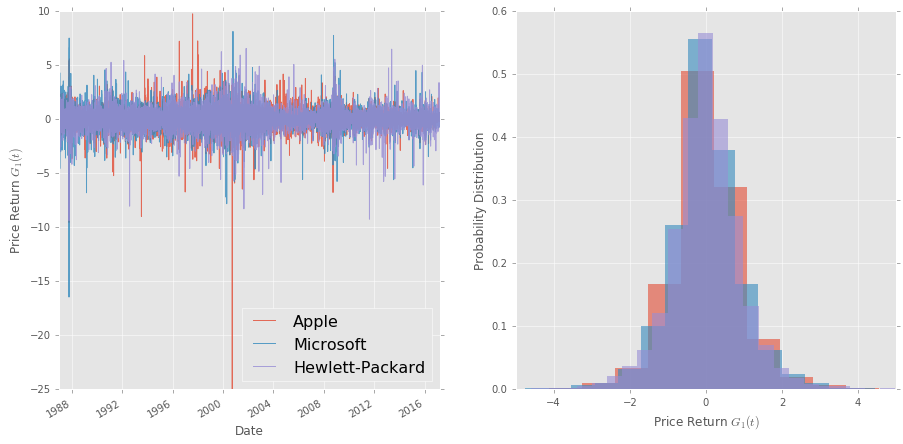

In [14]:
fig, [ax,bx] = plt.subplots(figsize=(15.0, 7.5),ncols=2)
for data,lbl in zip([apple, msft, hpq], ['Apple', 'Microsoft', 'Hewlett-Packard']):
    data['Return d1'].plot(ax=ax, alpha=0.8, legend=True, label=lbl)
    data['Return d1'].hist(ax=bx, alpha=0.6, normed=True, bins=40,lw=0)

ax.legend(loc=0, fontsize=16)
ax.set_ylabel('Price Return $G_1(t)$')
bx.set_xlabel('Price Return $G_1(t)$')
bx.set_ylabel('Probability Distribution')
bx.set_xlim([-5,5])
plt.show()

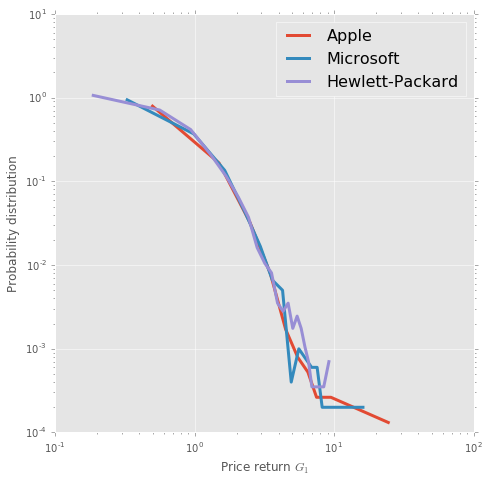

In [16]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
for data,lbl in zip([apple, msft, hpq], ['Apple', 'Microsoft', 'Hewlett-Packard']):
    edges,hist = pdf(np.abs(data['Return d1'].values), bins=25)
    ax.plot(edges, hist, label=lbl, lw=3)
ax.set_xlabel('Price return $G_1$')
ax.set_ylabel('Probability distribution')
ax.semilogy()
ax.semilogx()
ax.legend(loc=0, fontsize=16)
plt.show()

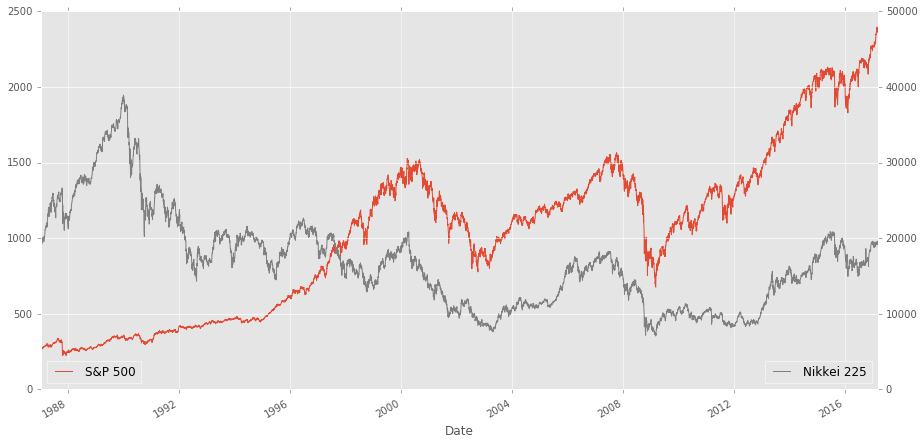

In [21]:
sp500 = pdr.DataReader('^GSPC', 'yahoo', start_time, end_time)
nikkei= pdr.DataReader('^N225', 'yahoo', start_time, end_time)

for stock in [sp500, nikkei]:
    computeReturn(stock, 'Return d1', 1)

fig,ax = plt.subplots(figsize=(15,7.5))
ax2 = ax.twinx()
sp500['Adj Close'].plot(ax=ax, legend = True,   label='S&P 500')
nikkei['Adj Close'].plot(ax=ax2, legend = True, label='Nikkei 225', color='grey')
ax.set_ylim([0, 2500])
ax2.set_ylim([0,50000])
ax.legend(loc=3)
ax2.legend(loc=4)
plt.show()

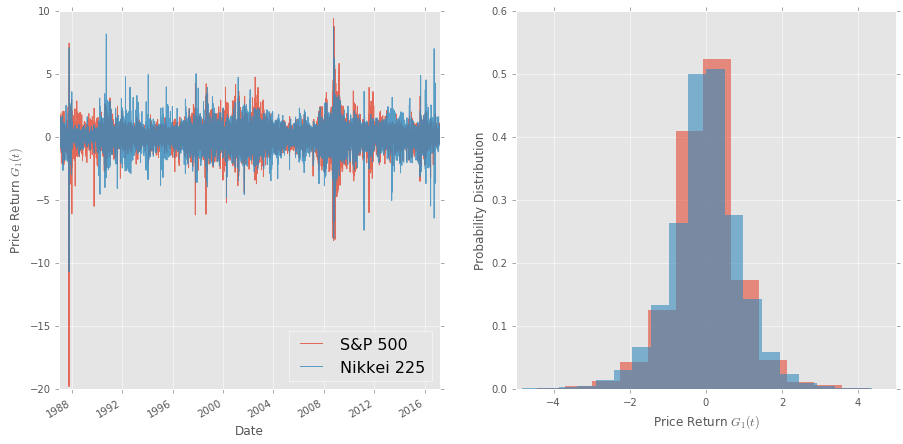

In [22]:
fig, [ax,bx] = plt.subplots(figsize=(15.0, 7.5),ncols=2)
for data,lbl in zip([sp500, nikkei], ['S&P 500', 'Nikkei 225']):
    data['Return d1'].plot(ax=ax, alpha=0.8, legend=True, label=lbl)
    data['Return d1'].hist(ax=bx, alpha=0.6, normed=True, bins=40,lw=0)

ax.legend(loc=0, fontsize=16)
ax.set_ylabel('Price Return $G_1(t)$')
bx.set_xlabel('Price Return $G_1(t)$')
bx.set_ylabel('Probability Distribution')
bx.set_xlim([-5,5])
plt.show()

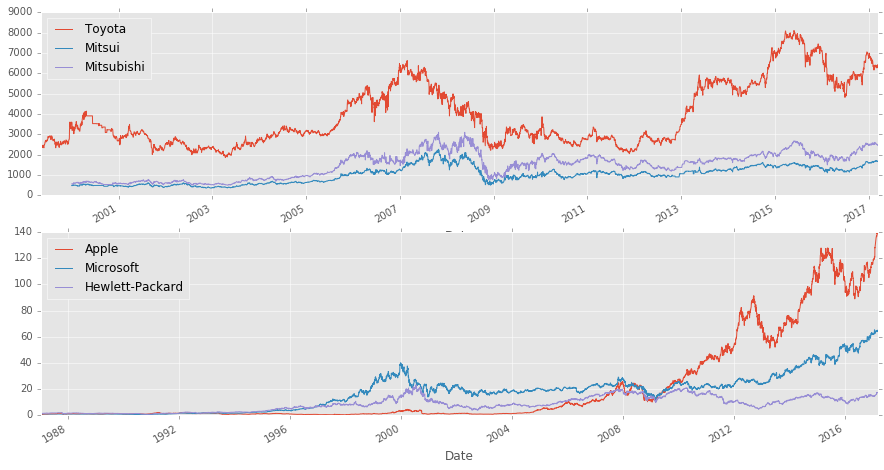

In [25]:
fig,[ax,bx] = plt.subplots(figsize=(15,8),nrows=2)
for stock,lbl in zip([toyota, mitsui, mitsubishi], ['Toyota', 'Mitsui', 'Mitsubishi']):
    stock['Adj Close'].plot(ax=ax, legend=True, label=lbl)
for stock,lbl in zip([apple, msft, hpq], ['Apple','Microsoft', 'Hewlett-Packard']):
    stock['Adj Close'].plot(ax=bx, legend=True, label=lbl)
plt.show()

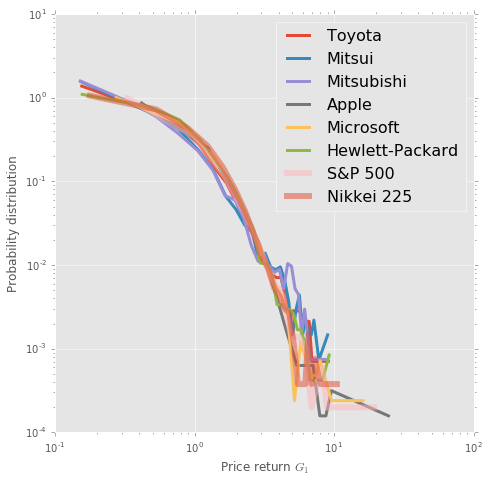

In [29]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
for stock,lbl in zip([toyota, mitsui, mitsubishi, apple, msft, hpq], 
                    ['Toyota', 'Mitsui', 'Mitsubishi', 'Apple', 'Microsoft', 'Hewlett-Packard']):
    edges,hist = pdf(np.abs(stock['Return d1']), bins=30)
    ax.plot(edges, hist, label=lbl, lw=3)
for stock,lbl in zip([sp500, nikkei], ['S&P 500', 'Nikkei 225']):
    edges,hist = pdf(np.abs(stock['Return d1']), bins=30)
    ax.plot(edges, hist, label=lbl, lw=6, alpha=0.5)
ax.set_xlabel('Price return $G_1$')
ax.set_ylabel('Probability distribution')
ax.semilogy()
ax.semilogx()
ax.legend(loc=0, fontsize=16)
plt.show()